In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from dpeva.uncertain.rnd import RandomNetworkDistillation

Initializing dpeva version 0.1.0


In [3]:
desc = np.load('desc.npy')
desc.shape

(20873, 136)

In [4]:
target_vector = desc.copy()  

# 初始化 RND 模块
input_dim = target_vector.shape[-1]  # 输入维度
output_dim = target_vector.shape[-1]   # 输出维度（与输入维度相同）
hidden_dim = 240  # 隐藏层维度
log_file = "rnd_training.log"  # 日志文件

# RND 训练部分
train_data = target_vector.copy()  

# 初始化 RND 训练器
rnd = RandomNetworkDistillation(
    input_dim=input_dim, output_dim=input_dim, hidden_dim=hidden_dim, 
    num_residual_blocks=1, distance_metric="cossim", use_normalization=False)

# 训练模型
rnd.train(train_data, 
          num_epochs=40, 
          batch_size=4096, 
          initial_lr=1e-3, 
          gamma=0.90, 
          loss_down_step=5,)

# 保存预测网络和目标网络
# rnd.save_predictor_network("rnd_predictor.pth")
# rnd.save_target_network("rnd_target.pth")

In [5]:
print(rnd.target_network)

RNDNetwork(
  (fc1): Linear(in_features=136, out_features=240, bias=True)
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (fc1): Linear(in_features=240, out_features=240, bias=True)
      (fc2): Linear(in_features=240, out_features=240, bias=True)
      (relu): ReLU()
    )
  )
  (fc2): Linear(in_features=240, out_features=136, bias=True)
  (relu): ReLU()
)


In [6]:
print(rnd.predictor_network)

RNDNetwork(
  (fc1): Linear(in_features=136, out_features=240, bias=True)
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (fc1): Linear(in_features=240, out_features=240, bias=True)
      (fc2): Linear(in_features=240, out_features=240, bias=True)
      (relu): ReLU()
    )
  )
  (fc2): Linear(in_features=240, out_features=136, bias=True)
  (relu): ReLU()
)


In [7]:
# 计算每个点的独特性（内在奖励）
intrinsic_rewards = []
batch_size = 4096  # 批量计算以提高性能

# 批量计算内在奖励
for i in range(0, len(target_vector), batch_size):
    batch = target_vector[i:i + batch_size]  # 获取当前批次数据
    batch_rewards = [rnd.get_intrinsic_reward(state) for state in batch]  # 计算批次中每个点的内在奖励
    intrinsic_rewards.extend(batch_rewards)

# 将内在奖励转换为 numpy 数组
intrinsic_rewards = np.array(intrinsic_rewards)

# 找到前 200 个最独特的点
top_200_indices = np.argsort(intrinsic_rewards)[-200:]  # 获取奖励值最大的 1000 个索引
top_200_points = target_vector[top_200_indices]  # 获取对应的点

# 输出结果
print("前 200 个最独特的点的索引：", top_200_indices)

前 200 个最独特的点的索引： [19067  8019  7523 12967 12467  1069 18338  1139 15915 13074 11438 19018
   112 19093 13858 15982 12454  1176  2097 19915  3556  1192 15272 19504
 15271 11437 19913 15922 12455   113   565 18848 11371 18291  3996 19046
  9800 11255  8040  3995  6720 11257 19195 13025 16561 18143 12974  8021
 19161 12460 19191 19095  7988 18981 19908 13843  5740  5771 16021 19204
 19203 19119 12973  5761 13058 15890 19132 19007 12975 11357 19084 12461
  7994   111  7385 13023  7521 19097  6166 19505 19914 16020 19305 16010
 15228 15227  5759  5738 18889 12450 11450 19009  4109  5769  1241 13857
  8962 12456 12463  4108 11441  3449  6060 13022  8022 15987  5739  6173
 12458   110  5722 17444 19147  4223  4210 15995  6749 18294 18342 19308
  7384 19088 12465 10367 19911 15894  6816 15908 18840 19150 15899 13850
 12459 19596 15966 16004  1182 18995  3599 13020 12952 19571 15906 15971
 15963 15939 15273 15936 15904 15981 18307 15957 15910 15948 20751 12960
  1288 12469  4474 10815  7520 124

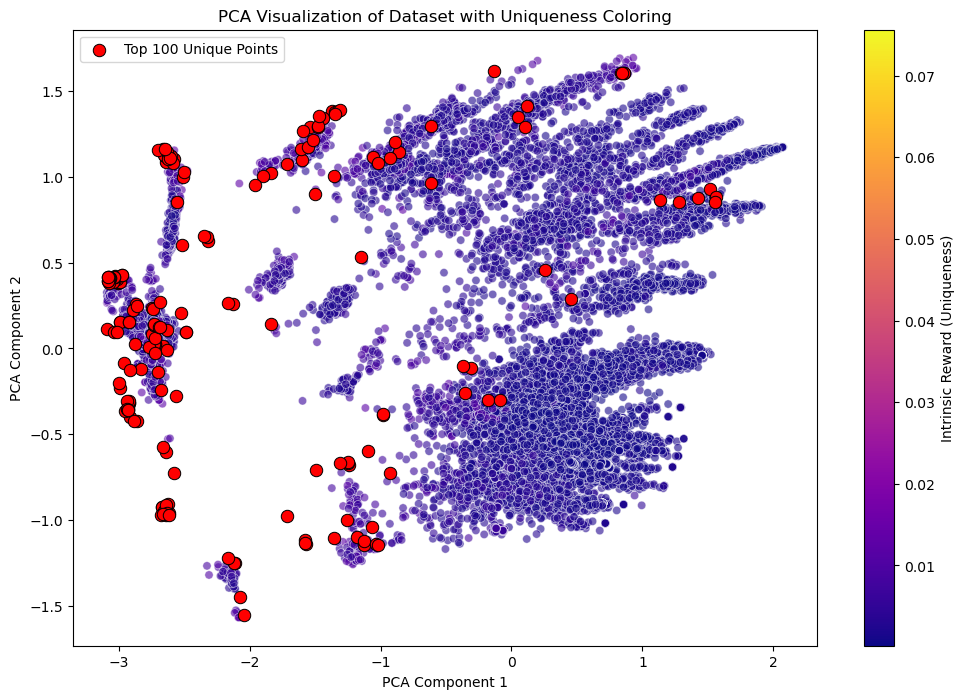

In [8]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


# PCA 可视化部分
# 使用 PCA 将数据降维到 2D
pca = PCA(n_components=2)  # 降维到 2D
pca_result = pca.fit_transform(target_vector)  # 对整个数据集进行 PCA 降维
top_200_pca_result = pca.transform(top_200_points)  # 对前 100 个最独特的点进行 PCA 降维

# 可视化
plt.figure(figsize=(12, 8))

# 绘制所有点，颜色表示独特性度量
ax = sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=intrinsic_rewards, palette="plasma", alpha=0.6, legend=False
)

# 绘制前 100 个最独特的点，用红色标注
sns.scatterplot(
    x=top_200_pca_result[:, 0], y=top_200_pca_result[:, 1],
    color="red", label="Top 100 Unique Points", s=80, edgecolor="black"
)

# 添加颜色条
norm = plt.Normalize(intrinsic_rewards.min(), intrinsic_rewards.max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Intrinsic Reward (Uniqueness)")  # 指定 ax 参数

# 添加标题和标签
plt.title("PCA Visualization of Dataset with Uniqueness Coloring")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

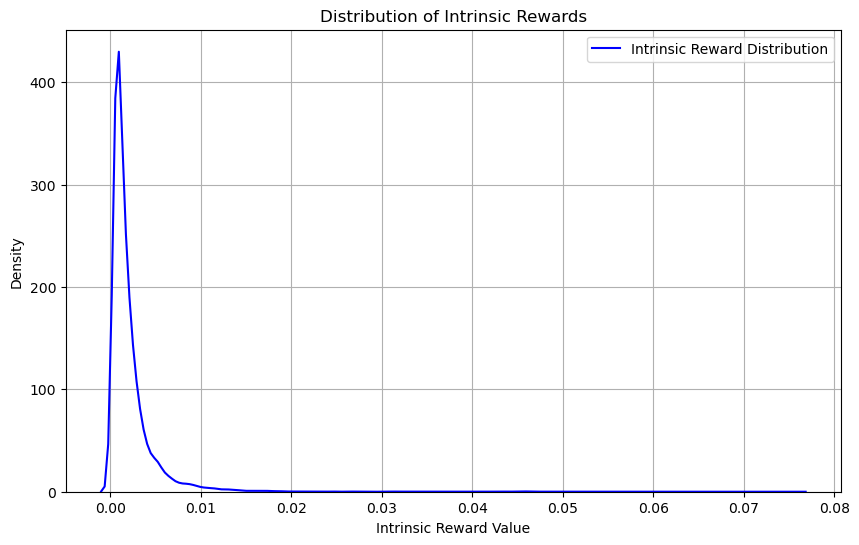

In [9]:
# 绘制内在奖励值的分布曲线图
plt.figure(figsize=(10, 6))
sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 使用核密度估计绘制分布曲线
plt.title("Distribution of Intrinsic Rewards")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

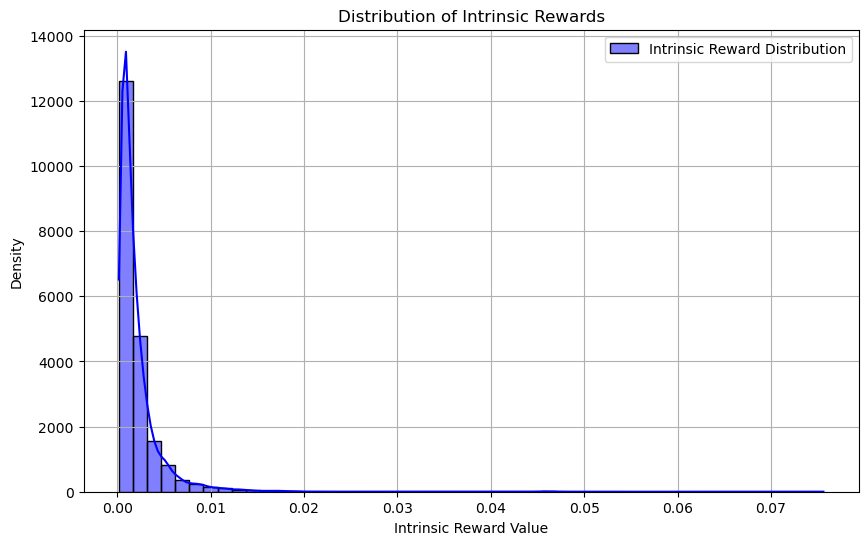

In [10]:
# 直接按照出现频率绘制内在奖励值的分布曲线图
plt.figure(figsize=(10, 6))
sns.histplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution", bins=50, kde=True)
plt.title("Distribution of Intrinsic Rewards")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()